In [1]:
import tensorflow as tf
tf.enable_eager_execution()

import numpy as np
import re
import matplotlib.pyplot as plt
from matplotlib import gridspec
from glob import glob
from tensorflow.keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Input, Lambda, MaxPooling2D, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Conv2D, Flatten, Input, GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from itertools import repeat
from collections import Counter
from mpl_toolkits.axes_grid1 import ImageGrid
import re
from scripts.constants import SEED
from pprint import pprint
import tensorflow_probability as tfp
import os
import datetime
import tensorflow.contrib.summary as tfsum
import pandas as pd
import random
from models.resnet import build_resnet50
from models.densenet import build_densenet121
from models.darknet19 import darknet19_detection
import gc
from tfdeterminism import patch
patch()
SEED = 234534
random.seed(SEED)
tf.random.set_random_seed(SEED)
np.random.seed(SEED)
from tensorflow.keras.models import Sequential
from tensorflow.keras.backend import set_session
from tensorflow.keras.backend import clear_session
from tensorflow.keras.backend import get_session
import tensorflow as tf

# Reset Keras Session


/home/stephan/anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/stephan/anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/stephan/anaconda3/envs/dam/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/stephan/anaconda3/envs/dam/lib/python3.6/site-

In [6]:
'''
config = tf.ConfigProto()
config.gpu_options.allow_growth=True
sess = tf.Session(config=config)
'''


config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1
config.gpu_options.allow_growth=True
config.gpu_options.visible_device_list = "0"
set_session(tf.Session(config=config))

params = {'channels':['B4','B3','B2','AVE','MNDWI'], 'num_classes':2, 'weights':'imagenet'}
channels = params.get('channels')

In [7]:
def parse_serialized_example(example_proto):
    ''' Parser function
    Useful for functional extraction, i.e. .map functions

    Args:
        example_proto: a serialized example

    Returns:
        A dictionary with features, cast to float32
        This returns a dictionary of keys and tensors to which I apply the transformations.
    '''
    # feature columns of interest
    featuresDict = {
        'B2': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # B
        'B3': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # G
        'B4': tf.io.FixedLenFeature([257, 257], dtype=tf.float32),  # R
        'AVE': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # Elevation
        'NDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'MNDWI': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'AWEISH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
        'AWEINSH': tf.io.FixedLenFeature([257, 257], dtype=tf.float32), # vegetation index
         #'index': tf.io.FixedLenFeature([1], dtype=tf.int64), # index
        'label': tf.io.FixedLenFeature([1], dtype=tf.float32) #label
    }

    return tf.io.parse_single_example(example_proto, featuresDict)

def stretch_image_colorspace(img):
    max_val = tf.reduce_max(img)
    return tf.cast(tf.divide(img, max_val), tf.float32)


#using a closure so we can add extra params to the map function from tf.Dataset
def parse_image(dims = [257, 257], channels = ['B4', 'B3', 'B2']):
    ''' Stack individual RGB bands into a N dimensional array
    The RGB bands are still separate 1D arrays in the TFRecords, combine them into a single 3D array
    
    Args:
        features: A dictionary with the features (RGB bands or other channels that need to be concatenated)
    '''
    
    # print("using the general image parsing function")
    def parse_image_fun(features):
        #channels = list(features.values())
        label = features['label']
        
        # Get the image channels, and NDWI/AVE channels separately
        # we cannot import them all at once since they need separate preprocessing steps
        img_chan = [features[x] for x in channels if x in ['B4', 'B3', 'B2']]
        ndwi_chan = [features[x] for x in channels if x in ['NDWI']]
        mndwi_chan = [features[x] for x in channels if x in ['MNDWI']]
        aweish_chan = [features[x] for x in channels if x in ['AWEISH']]
        aweinsh_chan = [features[x] for x in channels if x in ['AWEINSH']]
        ave_chan = [features[x] for x in channels if x in ['AVE']]
    
        
        # stack the individual arrays, remove all redundant dimensions of size 1, and transpose them into the right order
        # (batch size, H, W, channels)
        img = tf.transpose(tf.squeeze(tf.stack(img_chan)))
        
        # stretch color spaces of the RGB channels
        img = stretch_image_colorspace(img)
        
        if ndwi_chan:
            # further normalization? -> NDWI [-1,1]
            ndwi_chan = tf.divide(tf.add(ndwi_chan, 1), 1 + 1)
            img = tf.concat([img, tf.transpose(ndwi_chan)], axis= 2)
            
        if mndwi_chan:  
            # Range MNDWI: [-1,1]
            mndwi_chan = tf.divide(tf.add(mndwi_chan, 1), 1 + 1)
            img = tf.concat([img, tf.transpose(mndwi_chan)], axis= 2)
            
        if aweish_chan:
            img = tf.concat([img, tf.transpose(aweish_chan)], axis= 2)
            
        if aweinsh_chan:
            img = tf.concat([img, tf.transpose(aweinsh_chan)], axis= 2)
            
        if ave_chan:
            # normalization: https://developers.google.com/earth-engine/datasets/catalog/JAXA_ALOS_AW3D30_V1_1
            ave_chan = tf.divide(tf.add(ave_chan, 479) ,479 + 8859)
            img = tf.concat([img, tf.transpose(ave_chan)], axis= 2)
        
        # Additionally, resize the images to a desired size
        img = tf.image.resize(img, dims)
        return img, tf.reduce_max(tf.one_hot(tf.cast(label, dtype=tf.int32), 2, dtype=tf.int32), axis=0)
    
    return parse_image_fun

def validate(file_names, target_size, channels):
    files = tf.data.Dataset.list_files(file_names, shuffle=False)
    dataset = tf.data.TFRecordDataset(files, compression_type='GZIP')
    dataset = dataset.map(parse_serialized_example, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.map(parse_image(dims = target_size, channels = channels),
                          num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(32)
    dataset = dataset.apply(tf.data.experimental.ignore_errors())
    
    return dataset

In [8]:
data_path = 'datasets/data/train/drip-000.gz'

data = tf.data.TFRecordDataset(data_path, compression_type='GZIP')

data = data.map(parse_serialized_example)
data = data.map(parse_image(channels=channels))


(257, 257, 5)


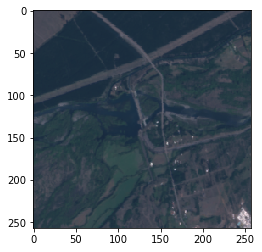

In [9]:
for x in data.take(1):
    img, label = x
    img = tf.image.resize(img, [257, 257])
    print(img.shape)
    plt.imshow(img[:,:,0:3].numpy())

img = img.numpy()

In [10]:
def load_model(model, params, weights, darknet=False):
    
    # Load original model and trained weights
    model_trained = model(**params)
    print("loading model weights")
    model_trained.load_weights(weights)

    extracted_weights = []
    for layer in model_trained.layers[0:2]:
        extracted_weights.append(layer.get_weights())

    #print(extracted_weights)
    
    # ===========================
    # define tail model (input)
    # ===========================
    inputs = Input(shape=(None, None, len(params.get('channels'))), name='inputlayer_0')
    x = Conv2D(3, (1,1))(inputs)
    new_model = Model(inputs=inputs, outputs=x)


    for i,layer in enumerate(new_model.layers):
        layer.set_weights(extracted_weights[i])
        
    #print(new_model.layers[1].get_weights())
    
    # ===========================
    # define head model (rest of the model)
    # ===========================
    altered_model_layers = model_trained.layers[2].layers
    
    if not darknet:
        #last_layers = model_trained.layers[3:]
        altered_model = Model(inputs=altered_model_layers[0].input, outputs=altered_model_layers[-1].output)

        output = GlobalAveragePooling2D()(altered_model.output)
        output = Dense(2, activation='softmax')(output)
        final_model = Model(inputs = altered_model_layers[0].input, outputs=output)
    else:
        final_model = Model(inputs=altered_model_layers[0].input, outputs=altered_model_layers[-1].output)
    
    #final_model.summary()

    # extract weights
    extracted_weights = []
    for layer in model_trained.layers[2].layers:
        extracted_weights.append(layer.get_weights())
        
    if not darknet:
        for layer in model_trained.layers[3:]:
            extracted_weights.append(layer.get_weights())
            

    # set weights for the model
    
    for i,layer in enumerate(final_model.layers):
        layer.set_weights(extracted_weights[i])
    
    print(model_trained.layers[2].layers[-3].get_weights())
    print(final_model.layers[-3].get_weights())
    
    return model_trained, new_model, final_model

In [26]:

'''
# Resnet
weights = 'checkpoints/aug_b4b3b2avemndwi/model-resnet50-best_f1-aug-ch_5-20200104-154223.hdf5'
model_trained, new_model, final_model = load_model(build_resnet50, params, weights)


# Densenet
weights = 'checkpoints/aug_b4b3b2avemndwi/model-densenet121-best_f1-aug-ch_5-20200105-021830.hdf5'
model_trained, new_model, final_model = load_model(build_densenet121, params, weights)
'''

# Darknet
weights = 'checkpoints/aug_b4b3b2avemndwi/model-darknet19-best_f1-aug-ch_5-20200105-022147.hdf5'
model_trained, new_model, final_model = load_model(darknet19_detection, params, weights, darknet=True)

instantiated model with weights: imagenet
Model: "model_23"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputlayer_0 (InputLayer)    [(None, None, None, 5)]   0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, None, None, 3)     18        
_________________________________________________________________
model_22 (Model)             (None, 2)                 50549986  
Total params: 50,550,004
Trainable params: 50,529,332
Non-trainable params: 20,672
_________________________________________________________________
loading model weights
[array([[[[ 0.05789895,  0.00058049],
         [-0.03517168,  0.02883072],
         [ 0.02364701,  0.02636154],
         ...,
         [ 0.02445907,  0.0165928 ],
         [ 0.00336301,  0.05978465],
         [ 0.01514792,  0.01420129]]]], dtype=float32), array([ 0.00570029, -0.00570025], dtype=float32)]
[

In [18]:
#val_data = validate(data_path, [257, 257], channels)
#preds = model_trained.predict(val_data)

In [28]:
final_model.summary()

Model: "model_25"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv_1 (Conv2D)                 (None, None, None, 3 864         input_7[0][0]                    
__________________________________________________________________________________________________
norm_1 (BatchNormalization)     (None, None, None, 3 128         conv_1[0][0]                     
__________________________________________________________________________________________________
leaky_re_lu_22 (LeakyReLU)      (None, None, None, 3 0           norm_1[0][0]                     
___________________________________________________________________________________________

(257, 257, 5) tf.Tensor([0 1], shape=(2,), dtype=int32)
(257, 257, 5) tf.Tensor([0 1], shape=(2,), dtype=int32)
(257, 257, 5) tf.Tensor([0 1], shape=(2,), dtype=int32)
(257, 257, 5) tf.Tensor([0 1], shape=(2,), dtype=int32)
(257, 257, 5) tf.Tensor([0 1], shape=(2,), dtype=int32)
(32, 257, 257, 5)
[[1.68287084e-02 9.83171284e-01]
 [5.57979569e-04 9.99442041e-01]
 [2.67929025e-03 9.97320712e-01]
 [1.67326548e-03 9.98326719e-01]
 [9.29150939e-01 7.08490089e-02]
 [5.62711013e-03 9.94372845e-01]
 [7.33898673e-03 9.92660999e-01]
 [5.88219613e-04 9.99411821e-01]
 [1.11411500e-03 9.98885930e-01]
 [5.68908313e-03 9.94310856e-01]
 [4.06390801e-02 9.59360957e-01]
 [2.00704249e-04 9.99799311e-01]
 [2.19718665e-01 7.80281305e-01]
 [6.62119419e-04 9.99337852e-01]
 [4.05027717e-02 9.59497213e-01]
 [3.38066998e-03 9.96619344e-01]
 [5.16242441e-03 9.94837582e-01]
 [8.08580965e-03 9.91914153e-01]
 [1.14292717e-02 9.88570750e-01]
 [8.14686573e-05 9.99918580e-01]
 [5.40463068e-03 9.94595349e-01]
 [2.94198

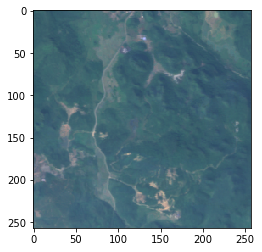

In [29]:
# make a resnet with altered top and load weights

for x in data.take(5):
    img, label = x
    img = tf.image.resize(img, [257, 257])
    print(img.shape, label)
    plt.imshow(img[:,:,0:3].numpy())

img = img.numpy()

preprocess_img = new_model.predict(img[np.newaxis,...])

preprocess_img.shape

for x in val_data.take(1):
    imgbatch, label = x
    print(imgbatch.shape)
    
preprocess_img = new_model.predict(imgbatch)
preprocess_img.shape


# create predictions

preds = final_model.predict(preprocess_img)
print(preds)

(-0.5, 256.5, 256.5, -0.5)

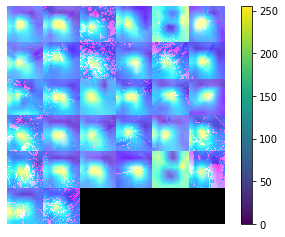

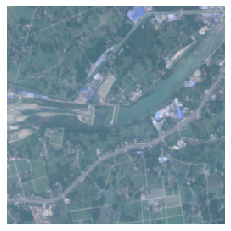

In [39]:
LAYER_NAME = 'conv2d_13'  # densenet'conv5_block16_2_conv',  darknet19: 'conv_22', resnet50: res5c_branch2c
CLASS_INDEX = 1
from tfexplain.tf_explain.core.grad_cam import GradCAM
explainer = GradCAM()
grid, cam = explainer.explain([preprocess_img, label], final_model, CLASS_INDEX, LAYER_NAME)

plt.imshow(grid)
plt.axis('off')
plt.colorbar()
plt.figure()
plt.imshow(img[:,:,0:3])
plt.axis('off')

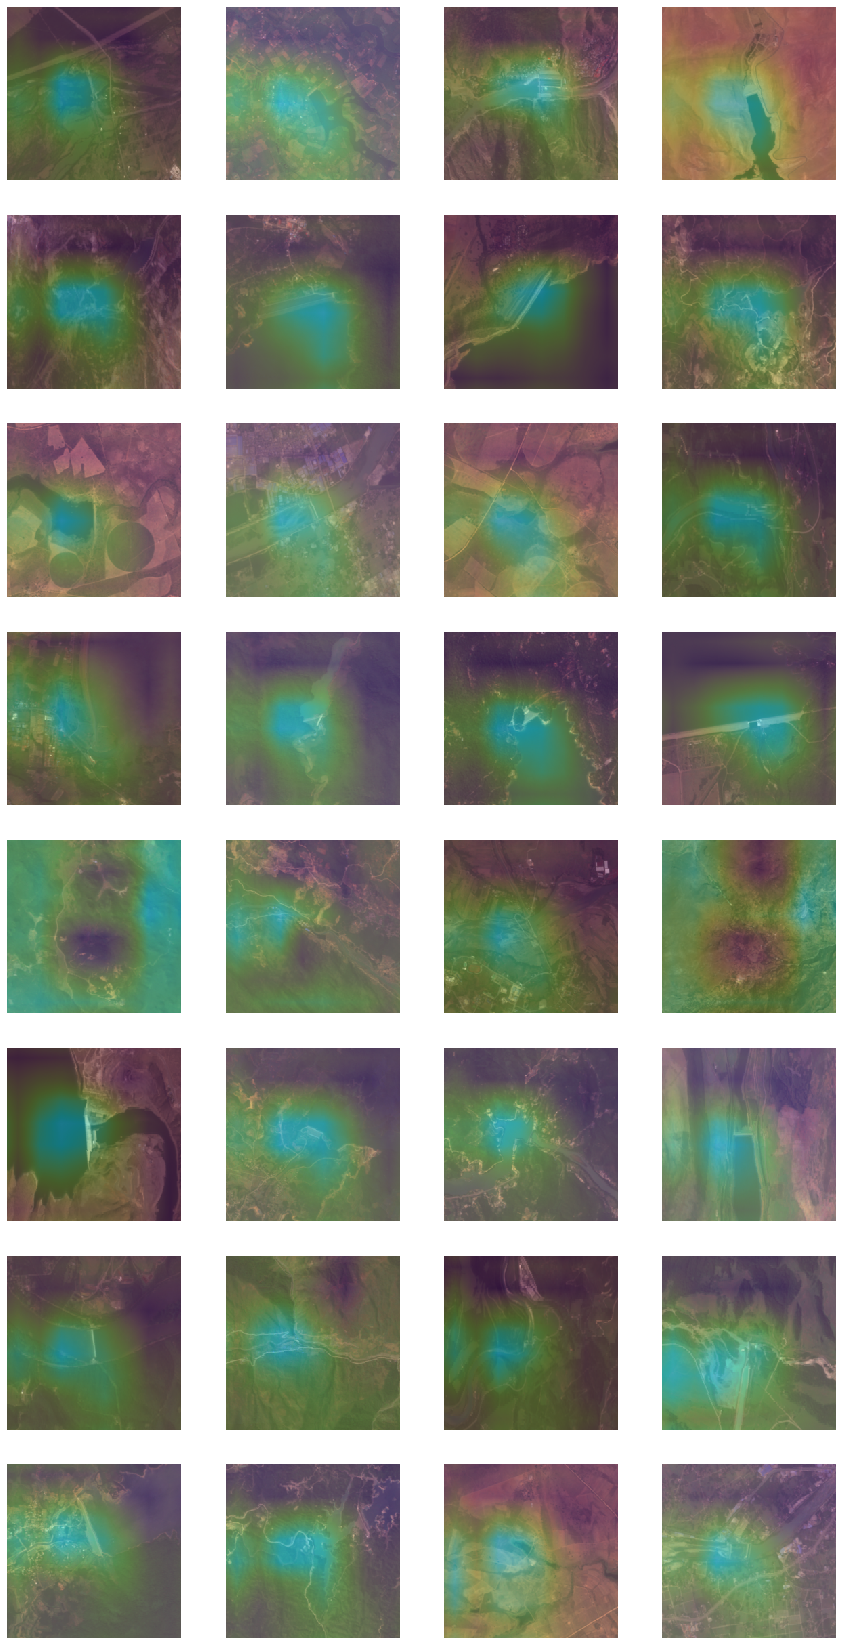

In [40]:
from skimage.transform import resize
import cv2

def image_to_uint_255(image):
    """
    Convert float images to int 0-255 images.

    Args:
        image (numpy.ndarray): Input image. Can be either [0, 255], [0, 1], [-1, 1]

    Returns:
        numpy.ndarray:
    """
    if image.dtype == np.uint8:
        return image

    if image.min() < 0:
        image = (image + 1.0) / 2.0

    return (image * 255).astype("uint8")

colormap = cv2.COLORMAP_VIRIDIS

imgbatch_uint8 = [image_to_uint_255(x[:,:,0:3].numpy()) for x in imgbatch]
outputs = []
heatmaps = []

for (heatmap, img) in zip(cam, imgbatch_uint8):
    heatmap = resize(heatmap.numpy(), (257,257),preserve_range=True)
    heatmap = ((heatmap - np.min(heatmap)) / (heatmap.max() - heatmap.min())) 
    heatmap = cv2.applyColorMap(
        cv2.cvtColor((heatmap * 255).astype("uint8"), cv2.COLOR_GRAY2BGR), colormap)
    heatmaps.append(heatmap)
    outputs.append(cv2.addWeighted(cv2.cvtColor(img, cv2.COLOR_RGB2BGR), 1, heatmap, 0.4, 0.0))

 
fig, axes = plt.subplots(8, 4)
fig.set_figheight(30)
fig.set_figwidth(15)
k = 0
for i in range(4):
    for j in range(8):
        #print(augment)
        axes[j, i].imshow(imgbatch_uint8[k])
        axes[j, i].imshow(heatmaps[k], alpha=0.45)
        axes[j, i].axis('off')
        k = k + 1
